# TF-IDF and K-Means Clustering
### Applied to the titles of 12,000 Etsy listings

In [1]:
# import libraries
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import silhouette_score

In [2]:
# import libraries for algorithm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [3]:
# import the dataset
df = pd.read_csv('data/titles-cleaned041022.csv')

In [4]:
df

,Unnamed: 0,title_listing
0,0,"['matte', 'black', 'mug']"
1,1,"['sample', 'second', 'sale', 'mug', 'coffee', ..."
2,2,"['mug', 'coffee', 'mug', 'tea', 'mug']"
3,3,"['espresso', 'cup', 'sake', 'cup', 'tumbler']"
4,4,"['mug', 'coffee', 'mug', 'tea', 'mug']"
...,...,...
11251,11251,"['plate', 'legs', 'organiser', 'small', 'fruit..."
11252,11252,"['vintage', 'art', 'object', 'letter', 'holder..."
11253,11253,"['jug', 'incised', 'design', 'milk', 'jug', 't..."
11254,11254,"['lava', 'fleck', 'vase']"


In [5]:
# remove the punctuation
df['title_string'] = df['title_listing'].apply(lambda x: re.sub("[^A-Za-z]+", " ", x))

In [6]:
# change the dataframe column to a series to use with the model
title = df['title_string']

TD-IDF Vectorization

In [7]:
# initialize the vectorizer
vector = TfidfVectorizer(sublinear_tf=True, min_df=0.005, max_df=0.4)

In [8]:
# Apply vectorizer and save array of vectors in V
V = vector.fit_transform(title)

In [9]:
V.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Apply K-means algorithm

### Find optimal number of clusters k Using the Elbow Method
Source: https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f

In [10]:
Sum_of_squared_distances = []
K = range(1,40)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(V)
    Sum_of_squared_distances.append(km.inertia_)

### NOTE: Where is the elbow?

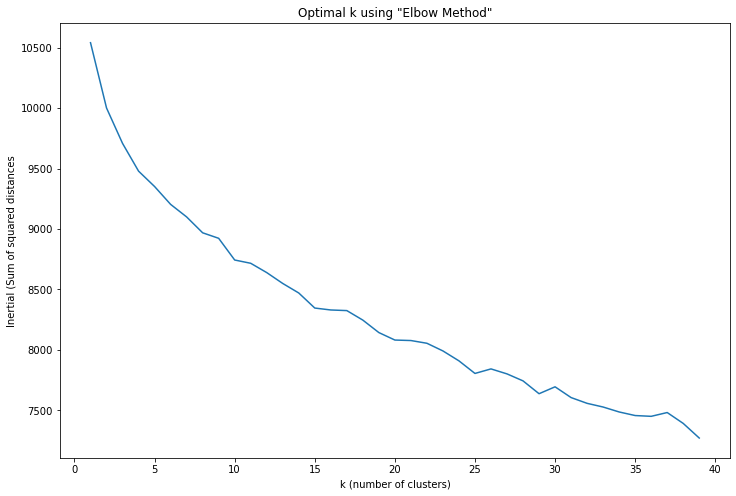

In [11]:
# plot the k values vs the inertia values
plt.figure(figsize=(12, 8))

sns.lineplot(x=K, y=Sum_of_squared_distances)

plt.xlabel('k (number of clusters)')
plt.ylabel('Inertial (Sum of squared distances')
plt.title('Optimal k using "Elbow Method"')

plt.show()

In [37]:
# intialize k-means
kmeans = KMeans(n_clusters=7, random_state = 42)

In [38]:
# fit the model to the vectors
kmeans.fit(V)

KMeans(n_clusters=7, random_state=42)

In [39]:
# store cluster labels in a variable
clusters = kmeans.labels_

#look at the cluster labels
[c for c in clusters][:20]

[5, 5, 5, 3, 5, 6, 2, 2, 2, 2, 0, 1, 5, 5, 2, 1, 6, 2, 1, 0]

In [40]:
# add clusters to the dataframe
df['cluster'] = clusters.tolist()

In [41]:
# calculate silhouette score
score = silhouette_score(V, kmeans.labels_, metric='euclidean')
score

0.066015976763781

In [21]:
# calculate the silhouette scores for the range of values indicated by the elbow method
# NOTE: the range for K cannot include 1
silhouette_scores = []
K = range(3,30)
for k in K:
    km = KMeans(n_clusters=k, random_state = 42)
    km = km.fit(V)
    silhouette_scores.append(silhouette_score(V, km.labels_, metric='euclidean'))

In [22]:
silhouette_scores

[0.05395271567479676,
 0.06297120010770567,
 0.059751030279417486,
 0.06274268878080823,
 0.0774189095436531,
 0.06790805379889764,
 0.07261973630202931,
 0.0647469603422901,
 0.07900544918311901,
 0.07794895633902886,
 0.07363945281921042,
 0.08889377807602335,
 0.07343789437845388,
 0.09539559645406324,
 0.07785244280366051,
 0.09593426121485137,
 0.0925834344772944,
 0.09428159342262253,
 0.09732065326231576,
 0.09022284502018157,
 0.09003243628190315,
 0.08172441058617771,
 0.09776978046628185,
 0.08412762914118439,
 0.09655862159979543,
 0.10231848796067725,
 0.08499376800277773]

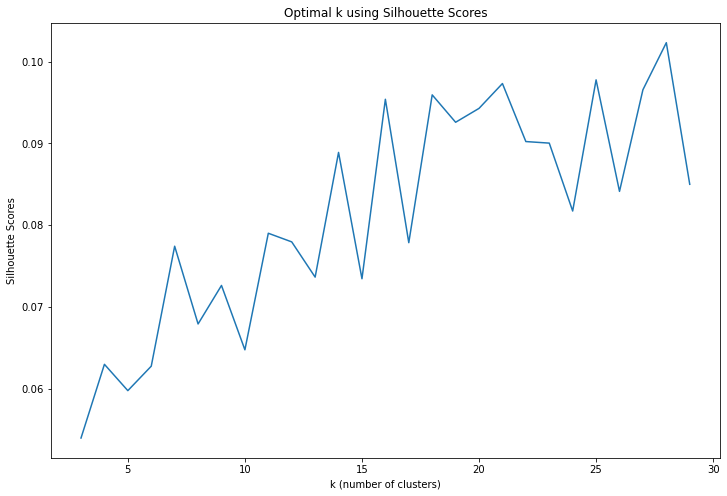

In [23]:
# plot the k values vs silhouette score
plt.figure(figsize=(12, 8))

sns.lineplot(x=K, y=silhouette_scores)

plt.xlabel('k (number of clusters)')
plt.ylabel('Silhouette Scores')
plt.title('Optimal k using Silhouette Scores')

plt.show()

Dimension Reduction and Visualization

In [42]:
# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)

# pass the vectors to the pca and store the vectors
vectorsPCA = pca.fit_transform(V.toarray())

# save the two dimensions
xD = vectorsPCA[:, 0]
yD = vectorsPCA[:, 1]

# add vectors and clusters to the dataframe
df['cluster'] = clusters
df['xD'] = xD
df['yD'] = yD

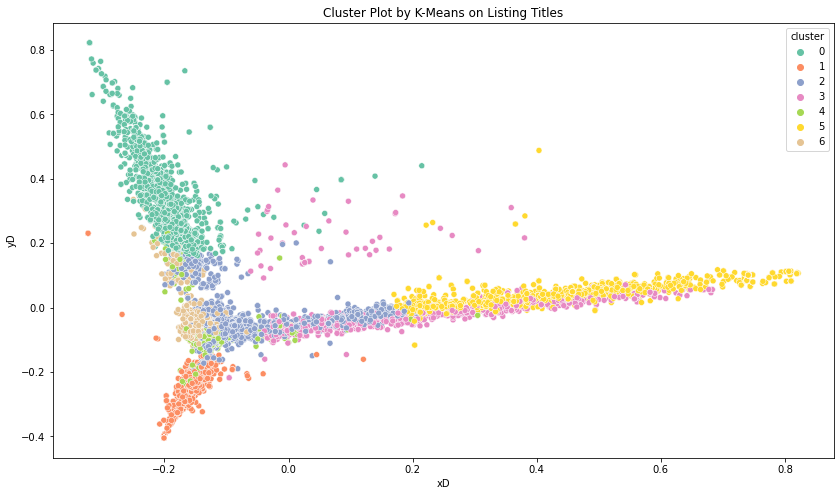

In [61]:
# plot the clusters
plt.figure(figsize=(14, 8))
sns.scatterplot(data=df, x="xD", y="yD", hue='cluster', palette="Set2")
plt.title('Cluster Plot by K-Means on Listing Titles')
plt.show()

In [44]:
# define a function that will find the top words for each cluster
def top_words(n):
    words_df = pd.DataFrame(V.todense()).groupby(clusters).mean()
    words = vector.get_feature_names()
    for i,r in words_df.iterrows():
        print('\nCluster {}'.format(i))
        print(', '.join([words[w] for w in np.argsort(r)[::-1][:n]]))

In [45]:
top_words(10)


Cluster 0
bowl, serving, blue, soup, large, white, salad, small, dish, green

Cluster 1
vase, flower, bud, blue, small, white, vintage, decor, home, black

Cluster 2
set, holder, blue, spoon, vintage, pendant, bowls, white, green, gift

Cluster 3
cup, coffee, mug, tea, espresso, tumbler, blue, white, gift, green

Cluster 4
pot, jar, planter, lidded, succulent, plant, lid, hanging, blue, vintage

Cluster 5
mug, coffee, tea, large, gift, blue, cup, unique, green, white

Cluster 6
plate, dish, soap, dinner, serving, butter, platter, set, small, dinnerware


In [57]:
# Use top words to assign categories to the clusters
categories = {0:'Bowl', 1:'Vase', 2:'Other', 3:'Cups', 4:'Jar/Pot', 5:'Mug', 6:'Plate'}

In [58]:
# map the category names to the listings
df['category'] = df['cluster'].map(categories)

In [63]:
df[df['category'] == 'Other'].head(60)

,Unnamed: 0,title_listing,title_string,cluster,xD,yD,category
6,6,"['bowls', 'graham', 'fern', 'set', 'bowls', 's...",bowls graham fern set bowls studio,2,-0.130797,-0.053837,Other
7,7,"['bowls', 'graham', 'fern', 'pair', 'bowls', '...",bowls graham fern pair bowls studio,2,-0.116716,-0.050343,Other
8,8,"['jug', 'graham', 'fern', 'studio']",jug graham fern studio,2,-0.106844,-0.088033,Other
9,9,"['jug', 'graham', 'fern', 'studio']",jug graham fern studio,2,-0.106844,-0.088033,Other
14,14,"['jug', 'milk', 'jug', 'creamer', 'brown', 'jug']",jug milk jug creamer brown jug,2,-0.107052,-0.082964,Other
17,17,"['blue', 'jug', 'celtic', 'jug', 'studio', 'pi...",blue jug celtic jug studio pitcher jug,2,-0.111380,-0.090117,Other
21,21,"['clinch', 'mountain', 'jug', 'winery', 'jug',...",clinch mountain jug winery jug moonshine jug ...,2,-0.103607,-0.083628,Other
23,23,"['raku', 'red', 'canister', 'deep', 'lid', 'ur...",raku red canister deep lid urn joppa mountain,2,-0.093448,-0.050681,Other
24,24,"['canister', 'lid', 'red', 'iris', 'urn', 'jop...",canister lid red iris urn joppa mountain,2,-0.090620,-0.058752,Other
25,25,"['canister', 'lid', 'dogwood', 'tree', 'white'...",canister lid dogwood tree white flowers joppa...,2,-0.095377,-0.067913,Other
